In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.

from matplotlib import pyplot as plt
import numpy as np
from gfloat import *
from gfloat.formats import format_info_ocp_e5m2

# Stochastic rounding

This notebook does some simple experiments with stochastic rounding.

The first is to plot the mean rounded value for a relatively small number of bits (2 bits). 

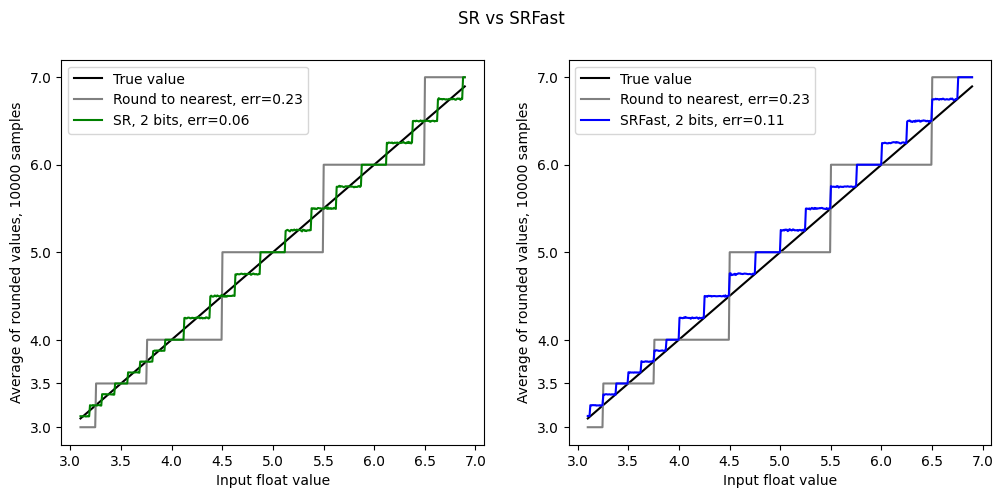

In [2]:
fi = format_info_ocp_e5m2

vs = np.arange(3.1, 6.9, 1 / 117)
# Round to nearest
rn = round_ndarray(fi, vs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("SR vs SRFast")

for rnd in (RoundMode.Stochastic, RoundMode.StochasticFast):
    SRFast = rnd == RoundMode.StochasticFast
    ax = ax1 if not SRFast else ax2
    ax.plot(vs, vs, label="True value", color="k")
    err_rn = np.abs(rn - vs).mean()
    ax.plot(vs, rn, label=f"Round to nearest, err={err_rn:.2f}", color="gray")

    # Stochastic rounding
    srnumbits = 2
    nsamples = 10_000
    srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

    rvs = round_ndarray(
        fi, vs[np.newaxis, :], rnd, sat=False, srbits=srbits, srnumbits=srnumbits
    )
    rvmean = rvs.mean(axis=0)
    err = np.abs(rvmean - vs).mean()
    color = "blue" if SRFast else "green"
    ax.plot(
        vs,
        rvmean,
        label=f"{'SRFast' if SRFast else 'SR'}, {srnumbits} bits, err={err:.2f}",
        color=color,
    )

    ax.set_xlabel("Input float value")
    ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
    ax.set_yticks(np.unique(rn))
    ax.legend()
None

We can see that, in simple terms, the green (pale) line on the left is closer to the black line than the (darker) blue line on the right.  That is, on average, stochastic rounding preserves accuracy that other roundings do not.  We can also see that the "SRFast" mode has a bias, in that rounded values are always above the y=x line, although the accuracy remains better than rounding to nearest.

To visualize the difference between "Stochastic" and "StochasticFast" rounding, let's
plot the rounding for a densely sampled set of values between two floats.

In OCP E5M2 format, the values 5 and 6 are adjacent floats.  Under NearestTiesToEven,
all values below 5.5 round to 5, the other values to 6.

We would plot this "rounding profile" as follows:

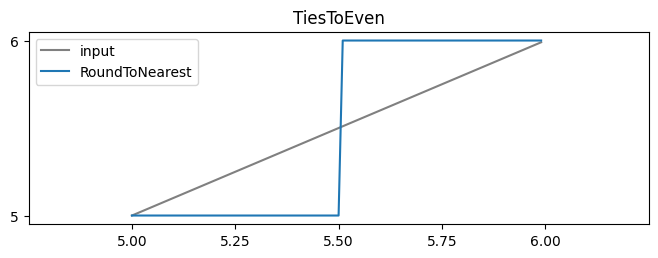

In [3]:
fig, ax = plt.subplots(figsize=(8, 2.5))
vs = np.arange(5, 6, 1 / 100)
r = round_ndarray(fi, vs, RoundMode.TiesToEven)
ax.plot(vs, vs, label=f"input", color="gray")
ax.plot(vs, r, label=f"RoundToNearest")
ax.set_xlim(4.75, 6.25)
ax.set_xticks(np.linspace(5, 6, 5))
ax.set_yticks([5, 6])
ax.legend()
ax.set_title(f"TiesToEven")
None

To consider the behaviour of stochastic rounding, think of it as selecting a random 
rounding profile based on the set of stochastic rounding bits.  Let us plot those 
profiles for SRNumBits=2, so there are four profiles.

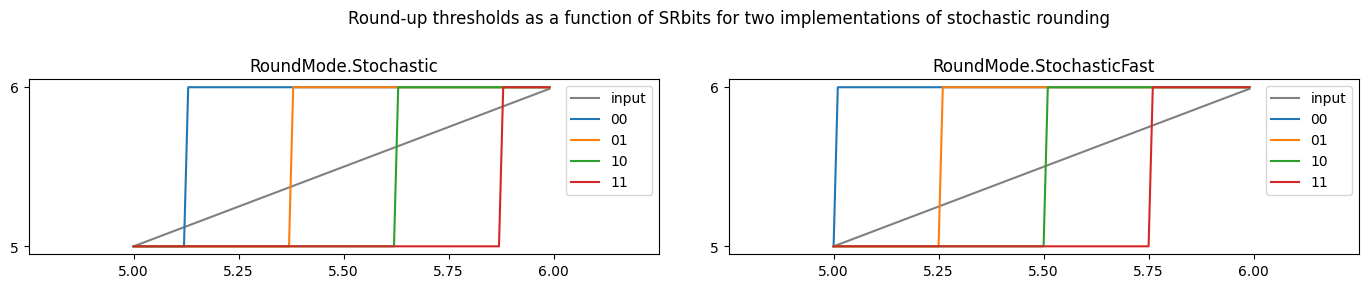

In [4]:
fig = plt.figure(figsize=(14, 2.5))
fig.suptitle(
    "Round-up thresholds as a function of SRbits for two implementations of stochastic rounding"
)
h = 0.7
axs = fig.add_axes((0, 0, 0.45, h)), fig.add_axes((0.5, 0, 0.45, h))
for rnd, ax in zip((RoundMode.Stochastic, RoundMode.StochasticFast), axs):
    vs = np.arange(5, 6, 1 / 100)
    ax.plot(vs, vs, label=f"input", color="gray")

    srnumbits = 2
    for srbits in range(2**srnumbits):
        r = round_ndarray(
            fi,
            vs,
            rnd,
            sat=False,
            srbits=np.full(vs.shape, srbits),
            srnumbits=srnumbits,
        )
        ax.plot(vs, r, label=f"{srbits:02b}")
    ax.set_xlim(4.75, 6.25)
    ax.set_xticks(np.linspace(5, 6, 5))
    ax.set_yticks([5, 6])
    ax.legend()
    ax.set_title(f"{rnd}")
None

It is evident that the Stochastic implementation selects from a more symmetric set of
profiles, illustrating why it is unbiased. 